<a href="https://colab.research.google.com/github/alexnic2000/Cod_Proiect_Licenta_Apostol_Alexandru_Nicolae/blob/main/Cod_Licenta_Python_Apostol_Alexandru_Nicolae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U -q tensorflow tensorflow_datasets
import os
import scipy
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import random
import shutil
import tensorflow as tf
from scipy.io.wavfile import write
from tensorflow.keras import layers
from tensorflow.keras import models
#os.mkdir('data/')
DATASET_PATH = 'data/'
data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
 tf.keras.utils.get_file('speech_commands.zip',origin='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',extract=True,cache_dir='.', cache_subdir='data')
os.mkdir('data/mydataset')
os.mkdir('data/mydataset/zero')
os.mkdir('data/mydataset/one')
os.mkdir('data/mydataset/two')
os.mkdir('data/mydataset/three')
os.mkdir('data/mydataset/four')
os.mkdir('data/mydataset/five')
os.mkdir('data/mydataset/six')
os.mkdir('data/mydataset/seven')
os.mkdir('data/mydataset/eight')
os.mkdir('data/mydataset/nine')
!cp -r 'data/zero' 'data/mydataset'
!cp -r 'data/one' 'data/mydataset'
!cp -r 'data/two' 'data/mydataset'
!cp -r 'data/three' 'data/mydataset'
!cp -r 'data/four' 'data/mydataset'
!cp -r 'data/five' 'data/mydataset'
!cp -r 'data/six' 'data/mydataset'
!cp -r 'data/seven' 'data/mydataset'
!cp -r 'data/eight' 'data/mydataset'
!cp -r 'data/nine' 'data/mydataset'


os.mkdir('data/mydataset/silent')
os.mkdir('data/mydataset/others')

other_labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'bed','bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow']
sample_per_label = 150
for label in other_labels:
  path = 'data/'+label
  f = os.listdir(path)
  num_files = len(f)
  file_indx = np.arange(num_files)
  random.shuffle(file_indx)
  for i in range(sample_per_label):
    index = file_indx[i]
    file_name = f[index]
    source = path + '/' + file_name
    destination = 'data/mydataset/others/' + file_name
  if os.path.isfile(source):
    shutil.copy(source, destination)

fs = 16000
num_files = 100
for i in range(num_files):
  sample = np.zeros(fs)
  filename = str(i*100)+ 'silent.wav'
  sample = sample + 0.1*random.randn(fs)
  scipy.io.wavfile.write('data/mydataset/silent/'+filename,fs,sample.astype(np.int16))




2428923189/2428923189 [==============================] - 20s 0us/step


In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(directory = 'data/mydataset',labels = 'inferred',batch_size=64,class_names=None,validation_split=0.2,seed=0, output_sequence_length=16000, subset= 'both')
label_names = np.array(train_ds.class_names)
print()
print('label names: ', label_names)


Found 39024 files belonging to 12 classes.
Using 31220 files for training.
Using 7804 files for validation.

label names:  ['eight' 'five' 'four' 'nine' 'one' 'others' 'seven' 'silent' 'six'
 'three' 'two' 'zero']


In [ ]:
train_ds.element_spec
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for sample_audio, sample_label in train_ds.take(1):
 print(sample_audio.shape)
 print(sample_label.shape)

(64, 16000)
(64,)


In [ ]:
from IPython import display
for i in range(5):
 indx = random.randint(0, sample_audio.shape[0]-1)
 label = label_names[sample_label[indx]]
 waveform = sample_audio[indx]
print('Label: ', label)
print('Audio shape: ', waveform.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label:  four
Audio shape:  (16000,)
Audio playback


In [ ]:
def get_spectrogram(waveform):
 # Convert the waveform to a spectrogram via STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=127, frame_step=64)
 # Obtain the absolute magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
 # Add a third dimension as channel, so that the spectrogram can be
 # as image-like input data with convolution layers (which expect
 # shape ('batch_size', 'height', 'width', 'channels').

  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
 # Convert the frequencies to log
 # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)

  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


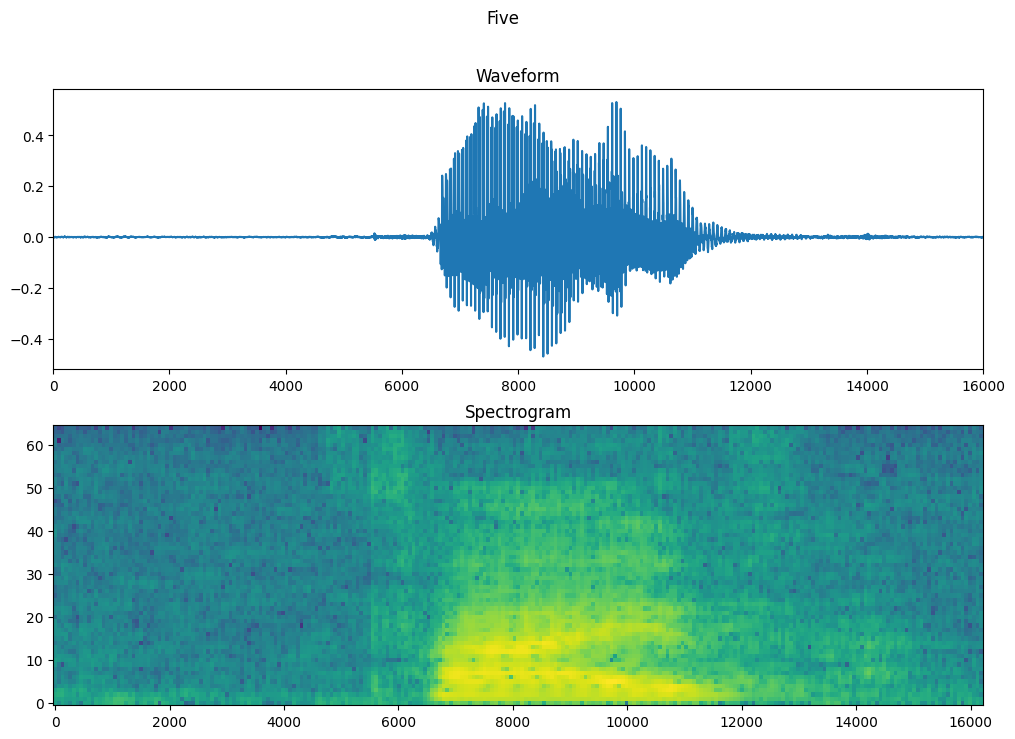

In [ ]:
indx = random.randint(0, sample_audio.shape[0]-1)
label = label_names[sample_label[indx]]
waveform = sample_audio[indx]
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [ ]:
print('Spectrogram shape:', spectrogram.shape)

Spectrogram shape: (249, 65, 1)


In [ ]:
def make_spectrogram_ds(ds):
  return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label),num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_spectrogram_ds = make_spectrogram_ds(train_ds)
val_spectrogram_ds = make_spectrogram_ds(val_ds)
test_spectrogram_ds = make_spectrogram_ds(test_ds)

In [ ]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.python.util.nest import flatten
from tensorflow.python.ops.gen_nn_ops import Conv2D
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  input_shape = example_spectrograms.shape[1:]
num_classes = 12
model = models.Sequential()
model.add(layers.Conv2D(8, (8, 8), strides=(2, 2), padding='SAME',activation='relu', input_shape=input_shape))
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes, activation = 'softmax'))


In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 125, 33, 8)        520       
                                                                 
 flatten_3 (Flatten)         (None, 33000)             0         
                                                                 
 dropout_3 (Dropout)         (None, 33000)             0         
                                                                 
 dense_3 (Dense)             (None, 12)                396012    
                                                                 
Total params: 396532 (1.51 MB)
Trainable params: 396532 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
model.fit(train_spectrogram_ds, validation_data=val_spectrogram_ds,epochs=100)

Epoch 1/100
488/488 [==============================] - 17s 30ms/step - loss: 1.5424 - accuracy: 0.5326 - val_loss: 1.3507 - val_accuracy: 0.5964
Epoch 2/100
488/488 [==============================] - 3s 6ms/step - loss: 1.2713 - accuracy: 0.6263 - val_loss: 1.2922 - val_accuracy: 0.6249
Epoch 3/100
488/488 [==============================] - 3s 6ms/step - loss: 1.1985 - accuracy: 0.6483 - val_loss: 1.2713 - val_accuracy: 0.6333
Epoch 4/100
488/488 [==============================] - 3s 6ms/step - loss: 1.1516 - accuracy: 0.6605 - val_loss: 1.2384 - val_accuracy: 0.6513
Epoch 5/100
488/488 [==============================] - 3s 6ms/step - loss: 1.1152 - accuracy: 0.6725 - val_loss: 1.2226 - val_accuracy: 0.6546
Epoch 6/100
488/488 [==============================] - 3s 5ms/step - loss: 1.0780 - accuracy: 0.6834 - val_loss: 1.2168 - val_accuracy: 0.6692
Epoch 7/100
488/488 [==============================] - 3s 6ms/step - loss: 1.0444 - accuracy: 0.6926 - val_loss: 1.2061 - val_accuracy: 0.66

In [ ]:
model.evaluate(test_spectrogram_ds)

61/61 [==============================] - 0s 5ms/step - loss: 2.8426 - accuracy: 0.8343


[2.842574119567871, 0.834272563457489]

In [ ]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_quant_model)
tflite_models_dir = pathlib.Path('/content/tflite_models/')
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/'model.tflite'
tflite_model_file.write_bytes(tflite_quant_model)

400296

In [ ]:
tflite_model_file = 'tflite_models/model.tflite'
 # Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()
input_info = interpreter.get_input_details()[0]
input_index = input_info['index']
scale, offset = input_info['quantization']
input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']
total_count = 0.0
accurate_count = 0.0
for x, y_true in test_spectrogram_ds:
  input_shape = x.shape[1:]
  for count in range(x.shape[0]):
    temp = x[count,:]
    temp = tf.reshape(temp,(1, temp.shape[0], temp.shape[1], temp.shape[2]))
    interpreter.set_tensor(input_index, temp)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)[0]
    prediction = np.argmax(prediction)
    if prediction == y_true[count].numpy():
      accurate_count += 1

    total_count += 1

accuracy = accurate_count/total_count
print('Accuracy : ', accuracy)

Accuracy :  0.8224897540983607


In [ ]:
!apt-get update && apt-get -qq install xxd
 # Convert to a C source file for Microcontrollers model
!xxd -i tflite_models/model.tflite > model.cc

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,230 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,254 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [1,079 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [962 kB]
Hit:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net